In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
from scipy import stats
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from sklearn.manifold import TSNE
import plotly.express as px
from umap import UMAP
from sklearn.decomposition import PCA


In [12]:
def load_matrix(data, matrix_size=400):
    # Determine the range of positions
    max_pos = data[['pos1', 'pos2']].max().max()
    min_pos = data[['pos1', 'pos2']].min().min()
    
    # Create bins
    bins = np.linspace(min_pos, max_pos, matrix_size + 1)
    
    # Create a mapping of positions to bins
    data['bin1'] = np.digitize(data['pos1'], bins) - 1
    data['bin2'] = np.digitize(data['pos2'], bins) - 1
    
    # Ensure bins do not exceed the matrix size
    data['bin1'] = data['bin1'].clip(upper=matrix_size - 1)
    data['bin2'] = data['bin2'].clip(upper=matrix_size - 1)
    
    # Create unique identifiers for each bin
    data['bin_id1'] = data['chr1'].astype(str) + '_' + data['bin1'].astype(str)
    data['bin_id2'] = data['chr2'].astype(str) + '_' + data['bin2'].astype(str)
    
    # Initialize the contact matrix
    contact_matrix = np.zeros((matrix_size, matrix_size))
    
    # Populate the contact matrix
    for _, row in data.iterrows():
        idx1 = row['bin1']
        idx2 = row['bin2']
        if idx1 != idx2:  # Ignore diagonal elements
            contact_matrix[idx1, idx2] += row['interaction']
            contact_matrix[idx2, idx1] += row['interaction']  # Assuming symmetry
    
    return contact_matrix


# Function to load all the matrices in a directory
def load_matrices(directory, contact_matrices, filepaths):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            # matrix = load_contact_matrix(filepath)
            matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
            contact_matrices.append(matrix)
            filepaths.append(filepath)
        

def plot_matrices(num_matrices, matrices_per_figure, contact_matrices):
    for start in range(0, num_matrices, matrices_per_figure):
        end = min(start + matrices_per_figure, num_matrices)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if start + i < end:
            matrix = contact_matrices[start + i]
            im = ax.imshow(matrix, cmap='coolwarm', interpolation='none')
            ax.set_title(f'Matrix {start + i + 1}')
            ax.set_xlabel('Position along Chromosome')
            ax.set_ylabel('Position along Chromosome')
            fig.colorbar(im, ax=ax, label='Interaction Frequency')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
    

def find_average(contact_matrices):
    average_list = []
    for matrix in contact_matrices:
        sum = 0
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                sum += matrix[i][j]
        avg = sum / (matrix.shape[0] * matrix.shape[1])
        average_list.append(avg)
    return average_list

def find_average_instance(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sum += matrix[i][j]
    return sum / (matrix.shape[0] * matrix.shape[1])

def matrix_avg_stats(average_list):
    avg = statistics.mean(average_list)
    sd = statistics.stdev(average_list)
    minimum = min(average_list)
    maximum = max(average_list)
    n = len(average_list)
    return {"average": avg, "standard deviation": sd, "minimum": minimum, "maximum": maximum, "count": n}

def find_max_shape_matrix(genotype: str) -> str:
    addr = ""
    max = (0, 0)
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        full = pd.read_csv(filepath, sep='\t', header=None)
        full.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        # Find unique values in column 2 (pos1) and column 4 (pos2)
        full_posx = full['pos1'].unique()
        full_posy = full['pos2'].unique()
        if len(full_posx) > max[0] and len(full_posy) > max[1]:
            max = (len(full_posx), len(full_posy))
            addr = filepath

    return addr

def augment(genotype:str, filepaths:list[str]) -> list[pd.DataFrame]:
    augmented_matrices = [] # Stores all augmented matrices

    max_size_file_path = find_max_shape_matrix(genotype)

    # Find the reference axes
    reference_data = pd.read_csv(max_size_file_path, sep='\t', header=None)
    # Assign column names
    reference_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
    # Find unique values in column 2 (pos1) and column 4 (pos2)
    unique_posx = reference_data['pos1'].unique()
    unique_posy = reference_data['pos2'].unique()

    # Find all (200, 200) full matrices
    full_matrices_dir = []
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        if os.path.isfile(filepath):
            matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
            if matrix.shape == (400, 400):
                full_matrices_dir.append(filepath)
                augmented_matrices.append(matrix)

    # Find all matrices that are not 200x200
    not_full_matrices = []
    for filepath in filepaths:
        if filepath not in full_matrices_dir:
            not_full_matrices.append(filepath)

    for filepath in not_full_matrices:
        temp_data = pd.read_csv(filepath, sep='\t', header=None)
        temp_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        temp_x = temp_data['pos1'].unique()
        temp_y = temp_data['pos2'].unique()
        matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
        diff_x = np.setdiff1d(unique_posx, temp_x)  # columns missing
        diff_y = np.setdiff1d(unique_posy, temp_y)  # rows missing
        missing_data = reference_data[reference_data['pos1'].isin(diff_x) | reference_data['pos2'].isin(diff_y)]
        aug_data = pd.concat([temp_data, missing_data], ignore_index=True)
        aug_matrix = load_matrix(aug_data)
        augmented_matrices.append(aug_matrix)
    return augmented_matrices

def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

def calculate_contact_probability(matrix):
    size = matrix.shape[0]
    probabilities = np.zeros(size)
    
    for d in range(size):
        contact_sum = 0
        count = 0
        for i in range(size - d):
            contact_sum += matrix[i, i + d]
            count += 1
        if count > 0:
            probabilities[d] = contact_sum / count
        else:
            probabilities[d] = 0
    
    return probabilities

def contact_probability_distance(matrix1, matrix2):
    # Calculate contact probabilities
    probabilities1 = calculate_contact_probability(matrix1)
    probabilities2 = calculate_contact_probability(matrix2)
    
    # Calculate the Euclidean distance between the two probability distributions
    distance = euclidean(probabilities1, probabilities2)
    return distance

def compare_matrices_with_windows(matrix1, matrix2, window_size=20):
    matrix_size = matrix1.shape[0]
    result_size = matrix_size // window_size
    result_matrix = np.zeros((result_size, result_size))
    
    for i in tqdm(range(result_size)):
        for j in range(result_size):
            window1 = matrix1[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            window2 = matrix2[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            distance = mean_absolute_error(window1, window2)
            result_matrix[i, j] = distance
            
    return result_matrix

def sum_of_squared_differences(matrix1, matrix2):
    return round(np.sum((matrix1 - matrix2) ** 2), 3)

def mean_absolute_error(matrix1, matrix2):
    return np.mean(np.abs(matrix1 - matrix2))

## Analysis for GM12878

In [199]:
# Directory containing the data files
directory = './GM12878'

In [200]:
# Load all contact matrices into a list
contact_matrices_GM12878 = []
filepaths_GM12878 = []

In [201]:
load_matrices(directory, contact_matrices_GM12878, filepaths_GM12878)

num_matrices = len(contact_matrices_GM12878)

print(num_matrices)


24


In [206]:
print(contact_matrices_GM12878[0].shape)

(400, 400)


In [202]:
augmented_matrices_GM12878 = augment(directory, filepaths_GM12878)


In [203]:
average_GM12878 = find_average(augmented_matrices_GM12878)

average_stats_GM12878 = matrix_avg_stats(average_GM12878)

print(average_GM12878)
print(average_stats_GM12878)

[0.0139, 0.0571625, 0.0227, 0.0298375, 0.0220375, 0.022825, 0.02175, 0.028, 0.0242375, 0.044625, 0.015875, 0.0193, 0.043425, 0.046825, 0.0734875, 0.04865, 0.026525, 0.033125, 0.0302625, 0.0272125, 0.0200375, 0.0451, 0.0302625, 0.0136875]
{'average': 0.03170208333333333, 'standard deviation': 0.01482396646933802, 'minimum': 0.0136875, 'maximum': 0.0734875, 'count': 24}


## Analysis for HAP1

In [204]:
directory = './HAP1'

# Load all contact matrices into a list
contact_matrices_HAP1 = []
filepaths_HAP1 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_HAP1, filepaths_HAP1)


num_matrices = len(contact_matrices_HAP1)

augmented_matrices_HAP1 = augment(directory, filepaths_HAP1)


average_HAP1 = find_average(augmented_matrices_HAP1)

average_stats_HAP1 = matrix_avg_stats(average_HAP1)

## Analysis for Hela

In [205]:
directory = './Hela'

# Load all contact matrices into a list
contact_matrices_Hela = []
filepaths_Hela = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_Hela, filepaths_Hela)


num_matrices = len(contact_matrices_Hela)

augmented_matrices_Hela = augment(directory, filepaths_Hela)


average_Hela = find_average(augmented_matrices_Hela)

average_stats_Hela = matrix_avg_stats(average_Hela)

In [212]:
directory = './K562'

# Load all contact matrices into a list
contact_matrices_K562 = []
filepaths_K562 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_K562, filepaths_K562)


num_matrices = len(contact_matrices_K562)

augmented_matrices_K562 = augment(directory, filepaths_K562)


average_K562 = find_average(augmented_matrices_K562)

average_stats_K562 = matrix_avg_stats(average_K562)

In [213]:
# Hypothesis testing:
# Null hypothesis: The given average belongs to the distribution.
avg_to_test = find_average_instance(augmented_matrices_GM12878[0])

t_statistic, p_value = stats.ttest_1samp(average_GM12878, avg_to_test)

# Print the test statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.0001

# Conclusion
if p_value < alpha:
    print("Reject the null hypothesis: The given average does not belong to the distribution.")
else:
    print("Fail to reject the null hypothesis: The given average belongs to the distribution.")
    


T-statistic: 5.8831785157321175
P-value: 5.371276344109521e-06
Reject the null hypothesis: The given average does not belong to the distribution.


In [214]:
print("GM12878 statistics:", average_stats_GM12878)
print("GM12878 averages:", average_GM12878)
print("avg of avg:", sum(average_GM12878) / len(average_GM12878))
print("====================================================")
print("HAP1 statistics:", average_stats_HAP1)
print("HAP1 averages:", average_HAP1)
print("avg of avg:", sum(average_HAP1) / len(average_HAP1))
print("====================================================")
print("Hela statistics:", average_stats_Hela)
print("Hela averages:", average_Hela)
print("avg of avg:", sum(average_Hela) / len(average_Hela))
print("====================================================")
print("K562 statistics:", average_stats_K562)
print("K562 averages:", average_K562)
print("avg of avg:", sum(average_K562) / len(average_K562))

print(len(average_GM12878), len(average_HAP1), len(average_Hela), len(average_K562))

GM12878 statistics: {'average': 0.03170208333333333, 'standard deviation': 0.01482396646933802, 'minimum': 0.0136875, 'maximum': 0.0734875, 'count': 24}
GM12878 averages: [0.0139, 0.0571625, 0.0227, 0.0298375, 0.0220375, 0.022825, 0.02175, 0.028, 0.0242375, 0.044625, 0.015875, 0.0193, 0.043425, 0.046825, 0.0734875, 0.04865, 0.026525, 0.033125, 0.0302625, 0.0272125, 0.0200375, 0.0451, 0.0302625, 0.0136875]
avg of avg: 0.031702083333333325
HAP1 statistics: {'average': 0.09300282170119957, 'standard deviation': 0.11168082515605943, 'minimum': 0.0132, 'maximum': 1.364775, 'count': 917}
HAP1 averages: [0.0437375, 0.1094125, 0.0348125, 0.0361, 0.0721625, 0.0211875, 0.045325, 0.2994, 0.1828375, 0.0214875, 0.0234, 0.082875, 0.1147625, 0.2155, 0.121725, 0.076325, 0.030275, 0.10035, 0.144225, 0.1606625, 0.0175625, 0.06005, 0.0508375, 0.0485375, 0.2738625, 0.0281875, 0.0207125, 0.210475, 0.026525, 0.0203, 0.0404875, 0.111575, 0.057975, 0.0152375, 0.14245, 0.06665, 0.19625, 0.0285625, 0.051225, 0.

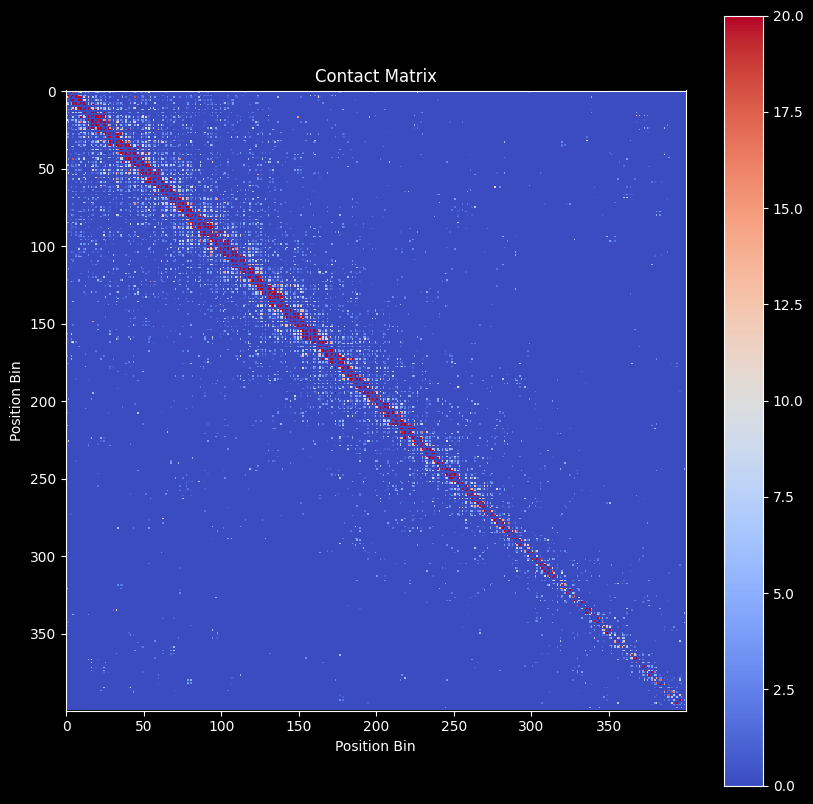

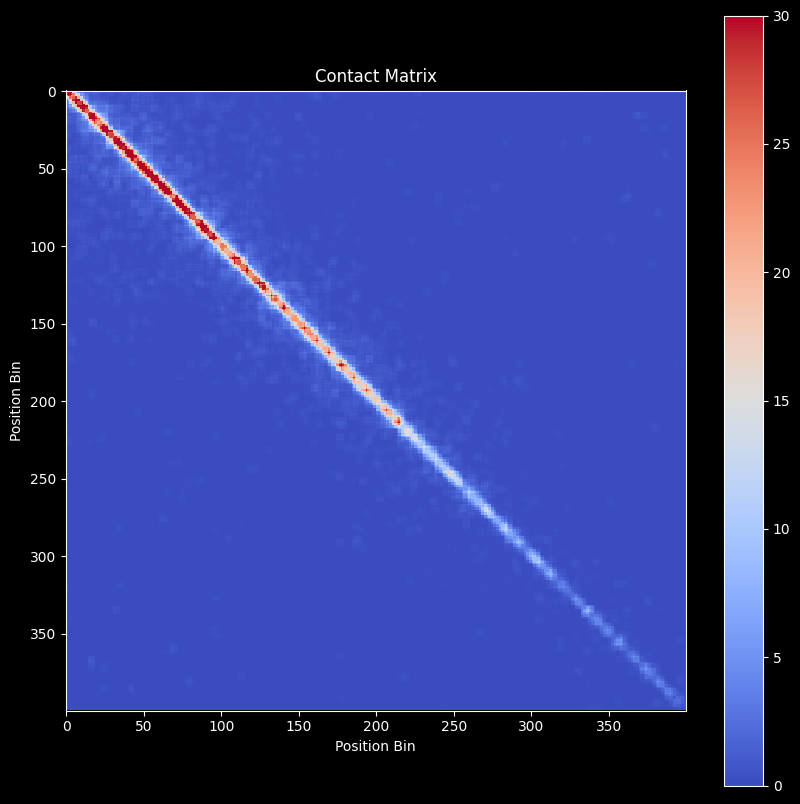

In [221]:
def apply_rolling_window_average(matrix, window_size=5):
    # Compute the cumulative sum along both axes
    cumsum = np.cumsum(np.cumsum(matrix, axis=0), axis=1)
    
    # Create an output matrix to store the averages
    smoothed_matrix = np.zeros_like(matrix)
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Define the boundaries of the window
            i_min = max(i - window_size // 2, 0)
            i_max = min(i + window_size // 2, matrix.shape[0] - 1)
            j_min = max(j - window_size // 2, 0)
            j_max = min(j + window_size // 2, matrix.shape[1] - 1)
            # Calculate the number of elements in the window
            num_elements = (i_max - i_min + 1) * (j_max - j_min + 1)
            # Calculate the sum of the elements in the window
            total = cumsum[i_max, j_max]
            if i_min > 0:
                total -= cumsum[i_min - 1, j_max]
            if j_min > 0:
                total -= cumsum[i_max, j_min - 1]
            if i_min > 0 and j_min > 0:
                total += cumsum[i_min - 1, j_min - 1]
            # Compute the average and assign it to the output matrix
            smoothed_matrix[i, j] = total / num_elements
    
    return smoothed_matrix

smoothed_matrix = apply_rolling_window_average(augmented_matrices_Hela[2])
# Plot the original matrix
visualize(augmented_matrices_Hela[2], 20)

visualize(smoothed_matrix, 30)

In [216]:
smoothed_GM12878 = [apply_rolling_window_average(matrix) for matrix in augmented_matrices_GM12878]
smoothed_HAP1 = [apply_rolling_window_average(matrix) for matrix in augmented_matrices_HAP1]
smoothed_Hela = [apply_rolling_window_average(matrix) for matrix in augmented_matrices_Hela]
smoothed_K562 = [apply_rolling_window_average(matrix) for matrix in augmented_matrices_K562]

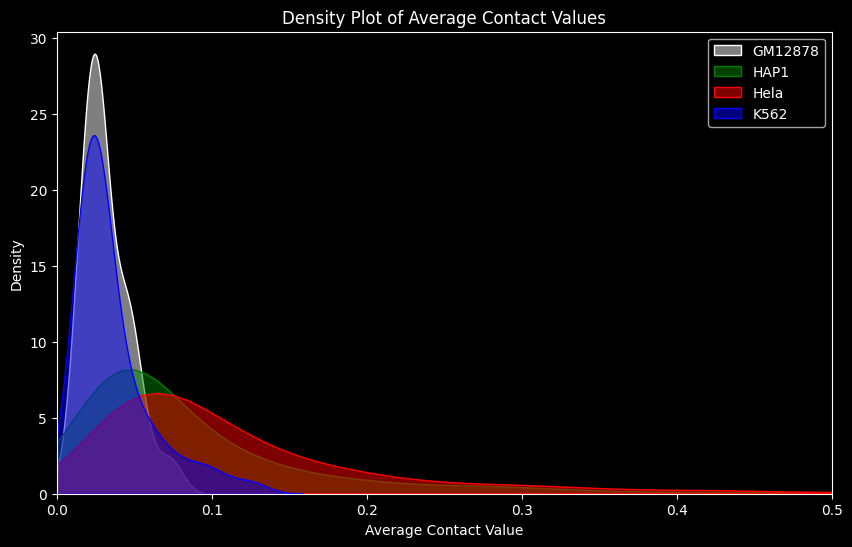

In [217]:
import seaborn as sns
data = [average_GM12878, average_HAP1, average_Hela, average_K562]
colors = ['white', 'green', 'red', 'blue']
labels = ['GM12878', 'HAP1', 'Hela', 'K562']

# Create the density plot
plt.figure(figsize=(10, 6))
for values, color, label in zip(data, colors, labels):
    sns.kdeplot(values, color=color, label=label, fill=True, alpha=0.5)

# Fix the x-axis range
plt.xlim(0, 0.5)

# Add titles and labels
plt.title('Density Plot of Average Contact Values')
plt.xlabel('Average Contact Value')
plt.ylabel('Density')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
# Provided function to compare matrices with windows
def compare_matrices_with_windows(matrix1, matrix2, window_size=20):
    matrix_size = matrix1.shape[0]
    result_size = matrix_size // window_size
    result_matrix = np.zeros((result_size, result_size))
    
    for i in range(result_size):
        for j in range(result_size):
            window1 = matrix1[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            window2 = matrix2[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            distance = mean_absolute_error(window1, window2)
            result_matrix[i, j] = distance
            
    return result_matrix

# Function to compute the average distance matrix from two sets of matrices
def compute_average_distance_matrix(set_a, set_b, window_size=10):
    # List to store the distance matrices
    distance_matrices = []

    # Compare all pairs of matrices from set A and set B
    for matrix_a in tqdm(set_a, desc='Comparing Set A to Set B'):
        for matrix_b in set_b:
            distance_matrix = compare_matrices_with_windows(matrix_a, matrix_b, window_size)
            distance_matrices.append(distance_matrix)
    
    # Compute the average distance matrix
    average_distance_matrix = np.mean(distance_matrices, axis=0)
    
    return average_distance_matrix

average_distance_matrix = compute_average_distance_matrix(augmented_matrices_HAP1, augmented_matrices_Hela, window_size=10)


# Find the indices of the top 5 highest scores in the average distance matrix
num_top_spots = 5
flat_indices = np.argpartition(average_distance_matrix.flatten(), -num_top_spots)[-num_top_spots:]
top_indices = np.unravel_index(flat_indices, average_distance_matrix.shape)

# Extract the top 5 values and their indices
top_values = average_distance_matrix[top_indices]
top_indices = list(zip(*top_indices))

print("Top 5 highest scores and their indices:")
for idx, val in zip(top_indices, top_values):
    print(f"Index: {idx}, Value: {val:.2f}")

# Plot the average distance matrix
plt.figure(figsize=(10, 10))
plt.imshow(average_distance_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Average Structural Similarity Index Matrix')
plt.xlabel('Window Position')
plt.ylabel('Window Position')

# Annotate the heatmap with the distance values
for i in range(average_distance_matrix.shape[0]):
    for j in range(average_distance_matrix.shape[1]):
        plt.text(j, i, f'{average_distance_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Highlight the top 5 highest scores
for idx, val in zip(top_indices, top_values):
    plt.text(idx[1], idx[0], f'{val:.2f}', ha='center', va='center', color='white', fontweight='bold', fontsize=10)

plt.show()


In [222]:
# Function to flatten matrices
def flatten_matrices(matrices):
    return [matrix.flatten() for matrix in matrices]

flattened_GM12878 = flatten_matrices(smoothed_GM12878)
flattened_HAP1 = flatten_matrices(smoothed_HAP1)
flattened_Hela = flatten_matrices(smoothed_Hela)
flattened_K562 = flatten_matrices(smoothed_K562)

all_matrices = flattened_GM12878 + flattened_HAP1 + flattened_Hela + flattened_K562
labels = (
    [1] * len(flattened_GM12878) +
    [2] * len(flattened_HAP1) +
    [3] * len(flattened_Hela) +
    [4] * len(flattened_K562)
)
all_matrices = np.array(all_matrices)
labels = np.array(labels)


In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=3, perplexity=50, learning_rate=100, random_state=42)
tsne_results = tsne.fit_transform(all_matrices)

# Create a scatter plot of the t-SNE results
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
df_tsne['Label'] = labels

# Plot the 3D t-SNE results using plotly
fig = px.scatter_3d(
    df_tsne, x='TSNE1', y='TSNE2', z='TSNE3',
    color=df_tsne['Label'].astype(str),  # Convert labels to string for better color differentiation
    title='3D t-SNE Visualization of Cell Line Clusters',
    labels={'color': 'Cell Line'}
)

fig.show()

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



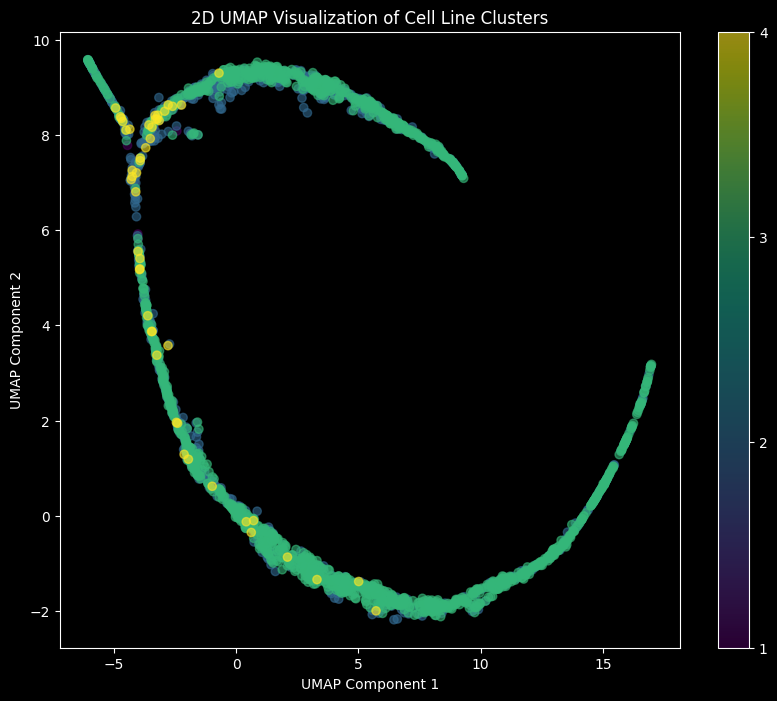

In [223]:
# Convert to NumPy arrays and ensure correct data types
all_matrices = np.array(all_matrices).astype(np.float64)
labels = np.array(labels).astype(np.int64)

# Apply UMAP with 2 components
umap_2d = UMAP(n_components=2, random_state=42)
umap_results_2d = umap_2d.fit_transform(all_matrices)

# 2D Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_results_2d[:, 0], umap_results_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=[1, 2, 3, 4])
plt.title('2D UMAP Visualization of Cell Line Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
# Apply UMAP with 3 components
umap_3d = UMAP(n_components=3, random_state=42)
umap_results_3d = umap_3d.fit_transform(all_matrices)

# 3D Visualization
df_umap_3d = pd.DataFrame(umap_results_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_umap_3d['Label'] = labels

fig = px.scatter_3d(
    df_umap_3d, x='UMAP1', y='UMAP2', z='UMAP3',
    color=df_umap_3d['Label'].astype(str),
    title='3D UMAP Visualization of Cell Line Clusters',
    labels={'color': 'Cell Line'}
)

fig.show()

In [224]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [225]:
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=200, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='correlation', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.0, # default 0.1, The effective minimum distance between embedded points.
              )
transformed_data = reducer.fit_transform(all_matrices)

In [226]:
chart(transformed_data, labels)

In [ ]:
def extract_windows(matrix, window_indices, window_size=10):
    """
    Extract specific windows from a matrix based on provided indices.

    Parameters:
    - matrix: 2D numpy array (200x200)
    - window_indices: List of tuples indicating the top-left corner of each window
    - window_size: Size of each window (default is 10)

    Returns:
    - windows: List of extracted windows
    """
    windows = []
    for (i, j) in window_indices:
        window = matrix[i:i+window_size, j:j+window_size]
        windows.append(window)
    return windows


# unique_window_indices = [(0, 0), (10, 10), (20, 20), (30, 30), (40, 40), (50, 50), (60, 60)]
unique_window_indices = [(0,0), (10, 10), (20, 20), (60, 60)]
windows = extract_windows(augmented_matrices_GM12878[0], unique_window_indices, window_size=10)
# Display the extracted windows
for idx, window in enumerate(windows):
    print(f"Window {idx+1}:\n{window}\n")

def flatten_and_concatenate_windows(windows):
    """
    Flatten each window and concatenate them to form a feature vector.

    Parameters:
    - windows: List of 2D numpy arrays (windows)

    Returns:
    - feature_vector: 1D numpy array representing the concatenated windows
    """
    feature_vector = np.concatenate([window.flatten() for window in windows])
    return feature_vector

def generate_feature_vectors(matrices, window_indices, window_size=10):
    feature_vectors = []
    for matrix in matrices:
        windows = extract_windows(matrix, window_indices, window_size)
        feature_vector = flatten_and_concatenate_windows(windows)
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

extracted_GM12878 = flatten_matrices(generate_feature_vectors(augmented_matrices_GM12878, unique_window_indices, window_size=10))
extracted_HAP1 = flatten_matrices(generate_feature_vectors(augmented_matrices_HAP1, unique_window_indices, window_size=10))
extracted_Hela = flatten_matrices(generate_feature_vectors(augmented_matrices_Hela, unique_window_indices, window_size=10))
extracted_K562 = flatten_matrices(generate_feature_vectors(augmented_matrices_K562, unique_window_indices, window_size=10))

extracted = extracted_GM12878 + extracted_HAP1 + extracted_Hela + extracted_K562
labels = (
    [1] * len(extracted_GM12878) +
    [2] * len(extracted_HAP1) +
    [3] * len(extracted_Hela) +
    [4] * len(extracted_K562)
)
extracted = np.array(extracted)
labels = np.array(labels)

transformed_data = reducer.fit_transform(extracted)
chart(transformed_data, labels)


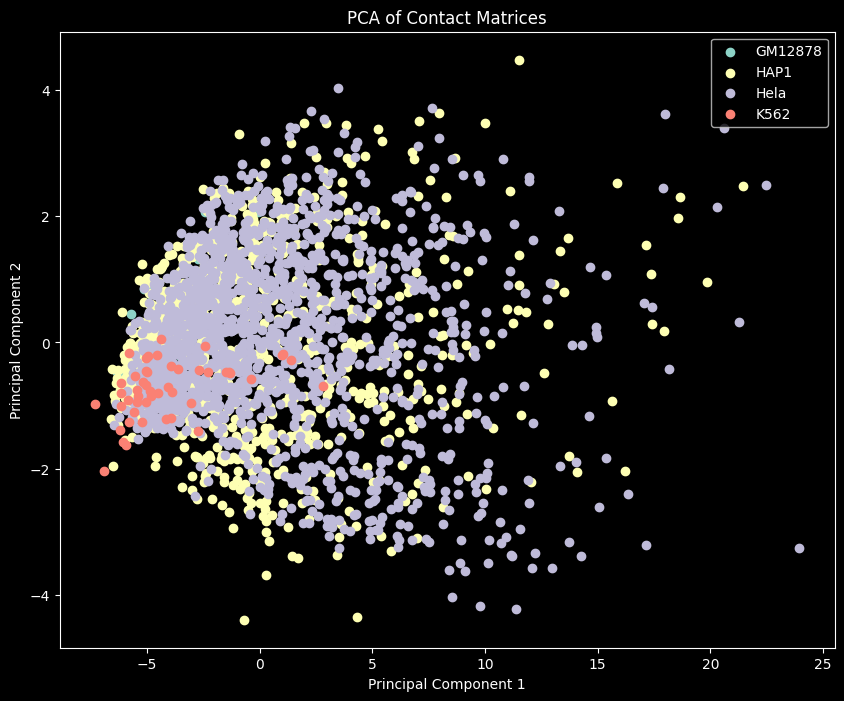

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to load and process matrices from a directory
def load_and_process_matrices(directory):
    matrices = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, sep='\t', header=None)
            df.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'contact_count']
            # Log10 transform contact counts
            df['contact_count'] = np.log10(df['contact_count'] + 1)
            # Binarize at 10 Mb resolution
            df['bin1'] = df['pos1'] // 10000000
            df['bin2'] = df['pos2'] // 10000000
            # Ensure redundant entries are only represented once
            df = df[df['chr1'] <= df['chr2']]
            matrices.append(df)
    return matrices

# Function to vectorize matrices
def vectorize_matrices(matrices):
    contacts = {}
    for df in matrices:
        for _, row in df.iterrows():
            contact = (row['chr1'], row['bin1'], row['chr2'], row['bin2'])
            if contact not in contacts:
                contacts[contact] = []
            contacts[contact].append(row['contact_count'])
    
    # Create a dataframe where rows are single cells and columns are contacts
    contact_list = list(contacts.keys())
    vectorized_data = []
    for df in matrices:
        cell_vector = []
        for contact in contact_list:
            chr1, bin1, chr2, bin2 = contact
            matching_rows = df[(df['chr1'] == chr1) & (df['bin1'] == bin1) & (df['chr2'] == chr2) & (df['bin2'] == bin2)]
            if not matching_rows.empty:
                cell_vector.append(matching_rows['contact_count'].values[0])
            else:
                cell_vector.append(0)
        vectorized_data.append(cell_vector)
    
    return pd.DataFrame(vectorized_data, columns=contact_list)

# Directories of the four types of cells
directories = ["./GM12878", "./HAP1", "./Hela", "./K562"]
labels = ["GM12878", "HAP1", "Hela", "K562"]

# Load, process, and vectorize matrices from each directory
all_matrices = []
all_labels = []
for i, directory in enumerate(directories):
    matrices = load_and_process_matrices(directory)
    all_matrices.extend(matrices)
    all_labels.extend([labels[i]] * len(matrices))

# Vectorize matrices
vectorized_matrix = vectorize_matrices(all_matrices)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectorized_matrix)

# Convert the PCA result to a dataframe
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['label'] = all_labels

# Plot the PCA result
plt.figure(figsize=(10, 8))
for label in labels:
    indices = pca_df['label'] == label
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], label=label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Contact Matrices')
plt.legend()
plt.show()


In [7]:
# Define bin size
BIN_SIZE = 1000000

# Function to parse the text files
def parse_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            data.append((parts[0], int(parts[1]), parts[2], int(parts[3]), int(parts[4])))
    return data

# Function to create a mapping for chromosome positions
def create_position_mapping(chromosomes, bin_size):
    position_map = {}
    index = 0
    for chr in chromosomes:
        pos = 0
        while pos < 3_000_000_000:  # Assuming the max chromosome length is less than 3 billion bases
            position_map[(chr, pos)] = index
            index += 1
            pos += bin_size
    return position_map

# Function to create an empty contact matrix
def create_contact_matrix(size):
    return np.zeros((size, size), dtype=int)

# Function to load data into a contact matrix
def load_data_into_matrix(data, position_map, size):
    matrix = create_contact_matrix(size)
    for chr1, pos1, chr2, pos2, contact in data:
        idx1 = position_map[(chr1, pos1)]
        idx2 = position_map[(chr2, pos2)]
        matrix[idx1, idx2] += contact
        if idx1 != idx2:
            matrix[idx2, idx1] += contact  # Ensure the matrix is symmetric
    return matrix

# Main function to process the directory and files
def process_directory(directory):
    # List of chromosomes to consider
    chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

    # Create the position mapping
    position_map = create_position_mapping(chromosomes, BIN_SIZE)

    # Determine the size of the contact matrix
    size = len(position_map)

    matrices = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            data = parse_file(file_path)
            matrix = load_data_into_matrix(data, position_map, size)
            matrices.append(matrix)

    return matrices



In [8]:
directory_path = "./GM12878"
GM = process_directory(directory_path)

In [13]:
visualize(GM[0], 20)

: 